In [227]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

In [45]:
embeds = pd.read_feather("data/final/text/embeds")
embeds[['Dyad', 'Session','speaker']] = embeds[['Dyad', 'Session','speaker']].astype(str)
embeds.head()

,Dyad,Session,begin_time,end_time,duration,utt,speaker,SD,QE,SV,...,758,759,760,761,762,763,764,765,766,767
0,6,1,0 days 00:00:12.088000,0 days 00:00:15.891000,0 days 00:00:03.803000,okay pause filler well hi,1,0,0,0,...,-0.025762,-0.528126,0.012002,-0.041885,0.167777,0.080773,-0.094413,0.058842,0.256732,0.275697
1,6,1,0 days 00:00:16.260000,0 days 00:00:16.784000,0 days 00:00:00.524000,hi,2,0,0,0,...,0.033261,-0.241042,0.047376,-0.080213,0.114003,-0.021580,-0.083342,0.037995,0.149979,0.432427
2,6,1,0 days 00:00:17.955000,0 days 00:00:22.348000,0 days 00:00:04.393000,pause filler I think I like met you at that li...,1,0,0,0,...,0.096455,-0.294072,0.079524,-0.119018,0.326904,-0.041721,-0.093160,-0.019781,0.309670,0.298224
3,6,1,0 days 00:00:22.561000,0 days 00:00:23.369000,0 days 00:00:00.808000,yeah,2,0,0,0,...,0.054642,-0.232961,0.133846,-0.213903,0.144901,-0.004387,-0.115766,-0.072333,0.274199,0.196598
4,6,1,0 days 00:00:23.768000,0 days 00:00:27.794000,0 days 00:00:04.026000,I remember you were wearing like the (inaudibl...,1,0,0,0,...,-0.021082,-0.290527,0.143484,-0.059674,0.238624,0.088079,-0.163877,-0.024338,0.258010,0.249274


In [49]:
partA = pd.read_feather("data/final/opensmile/partA05")
partA[['Dyad', 'Session']] = partA[['Dyad', 'Session']].astype(str)
partB = pd.read_feather("data/final/opensmile/partA05")
partB[['Dyad', 'Session']] = partB[['Dyad', 'Session']].astype(str)
partA_f = pd.read_feather("data/final/openface/partA05")
partA[['Dyad', 'Session']] = partA[['Dyad', 'Session']].astype(str)
partB_f = pd.read_feather("data/final/openface/partA05")
partB[['Dyad', 'Session']] = partB[['Dyad', 'Session']].astype(str)
partA.head()

,Dyad,Session,timestamp,F0semitoneFrom27.5Hz,F1amplitudeLogRelF0,F1bandwidth,F1frequency,F2amplitudeLogRelF0,F2frequency,F3amplitudeLogRelF0,...,logRelF0-H1-A3,logRelF0-H1-H2,mfcc1,mfcc2,mfcc3,mfcc4,shimmerLocaldB,slope0-500,slope500-1500,spectralFlux
0,10,1,0 days 00:00:00,18.888903,-63.353821,1325.566650,447.323639,-72.431046,1327.725952,-73.342484,...,9.182055,-1.028202,26.670574,-0.271010,32.115246,-14.591258,0.713881,0.004424,-0.013185,0.426167
1,10,1,0 days 00:00:00.500000,13.325543,-102.095062,1445.927979,614.912231,-110.130447,1492.236572,-109.559265,...,7.046906,1.454406,11.713121,19.083187,13.147476,11.931163,1.084428,-0.005640,-0.007394,0.517174
2,10,1,0 days 00:00:01,18.731268,-46.438793,1367.386841,461.698975,-57.257072,1405.162842,-57.278423,...,14.119520,4.224387,36.249199,-3.886767,28.169104,9.255716,1.435749,-0.004793,-0.010591,0.503940
3,10,1,0 days 00:00:01.500000,14.887599,-83.354271,1605.328369,486.535339,-95.766541,1417.770996,-93.753448,...,7.632737,-1.687447,20.054014,19.914509,12.125703,15.223460,0.980294,-0.011711,-0.008742,0.251282
4,10,1,0 days 00:00:02,0.000000,-201.000000,1540.564697,510.060852,-201.000000,1277.777588,-201.000000,...,0.000000,0.000000,26.494375,13.745218,3.665736,17.470032,0.000000,-0.035591,-0.001524,0.079330


In [52]:
def retrieve_frames(df, row):
    d = row.Dyad
    s = row.Session
    b = row.begin_time
    e = row.end_time
    return list(df.query("Dyad==@d & Session==@s & timestamp >= @b & timestamp < @e").index)

In [61]:
opensmile_index_A = {
    int(i) : retrieve_frames(partA,row) for (i,row) in embeds.loc[embeds.speaker=='1'].iterrows()
}
opensmile_index_B = {
    int(i) : retrieve_frames(partB,row) for (i,row) in embeds.loc[embeds.speaker=='2'].iterrows()
}
openface_index_A = {
    int(i) : retrieve_frames(partA_f,row) for (i,row) in embeds.loc[embeds.speaker=='1'].iterrows()
}
openface_index_B = {
    int(i) : retrieve_frames(partB_f,row) for (i,row) in embeds.loc[embeds.speaker=='2'].iterrows()
}

In [62]:
#import json
#
#with open("data/final/opensmile/partA_index.txt", "w") as fp:
#    json.dump(opensmile_index_A, fp)
#with open("data/final/opensmile/partB_index.txt", "w") as fp:
#    json.dump(opensmile_index_B, fp)
with open("data/final/openface/partA_index.txt", "w") as fp:
    json.dump(openface_index_A, fp)
with open("data/final/openface/partB_index.txt", "w") as fp:
    json.dump(openface_index_B, fp)

In [54]:
opensmile_index_A = {
    int(i) : retrieve_frames(partA,row) for (i,row) in embeds.loc[(embeds.speaker=='1') & (embeds.Dyad=='10')].iterrows()
}

In [57]:
with open("data/final/opensmile/partA_index.txt", "r") as fp:

    person_dict = json.load(fp)

In [210]:
target_col = embeds[['SD', 'QE', 'SV', 'PR', 'HD']].columns
feat_col = partA.iloc[:,3:].columns

X = torch.from_numpy(partA[feat_col].values).to(torch.float32)
Y = torch.from_numpy(embeds[target_col].values).to(torch.float32)

class_weights = Y.sum(dim=0) / Y.shape[0]

In [198]:
indexes = [*openface_index_A.keys()]
lim = int(len(indexes)*0.75)
shuffle(indexes)
train, test = indexes[:lim], indexes[lim:]

In [216]:
class monDataSet(Dataset):
    def __init__(self, dic, X, Y):
        self.index = list(dic.keys())
        self.dic = dic
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.dic)

    def __getitem__(self, idx):
        feats = X[ self.dic[idx] ,:]
        target = Y[idx]
        return feats,target
DS = monDataSet(opensmile_index_A, X, Y) #input 23 features, output 5 cats

In [256]:
class GRUModel(nn.Module):
    def __init__(self, input_dim=23, hidden_dim=8, layer_dim=3, output_dim=5, dropout_prob=.1):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.s = nn.Sigmoid()

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[-1]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        out = self.s(out)

        return out

rnn = GRUModel()

In [230]:
def train_model(model, DS, train_set, test_set, class_weights, batch_size=20, num_epochs=10, lr=0.01):

    train_loss=[]
    test_loss=[]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        shuffle(train)

        model.train()

        epoch_average_loss = 0.0

        batch_loss=0.0

        for i in train_set:

            x,y = DS[i]

            if len(x)==0:continue

            y_pre = model(x)
            batch_loss+=criterion(y_pre, y)

            if i%batch_size==0:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                epoch_average_loss += batch_loss.item() * batch_size / len(train_set)
                batch_loss=0.0

        train_loss.append(epoch_average_loss)
        test_loss.append(test_model(model, criterion, DS, test_set))

    return train_loss, test_loss

def test_model(model,criterion, DS, test_set):
    model.eval()
    loss = 0.0
    for i in test_set:
        x,y = DS[i]
        if len(x)==0:continue
        y_pre = model(x)
        loss+=criterion(y_pre, y)
    return loss

In [259]:
def train_model(model, DS, train_set, test_set, class_weights, batch_size=20, num_epochs=10, lr=0.01):

    train_loss=[]
    test_loss=[]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    def calc_loss(i):
        x,y = DS[i]
        if len(x)==0:return 0.0
        return criterion(model(x), y)

    for epoch in range(num_epochs):

        shuffle(train)

        model.train()

        epoch_average_loss = 0.0

        n_batch = len(train)//batch_size

        i=0
        while i+batch_size -1 < len(train):

            idx = train[i:i+batch_size]
            i+=batch_size

            batch_loss = sum([calc_loss(i) for i in idx])

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            epoch_average_loss += batch_loss.item() * batch_size / len(train_set)

        train_loss.append(epoch_average_loss)
        test_loss.append(test_model(model, criterion, DS, test_set))

    return train_loss, test_loss

def test_model(model,criterion, DS, test_set):
    model.eval()
    def calc_loss(i):
        x,y = DS[i]
        if len(x)==0:return 0.0
        return criterion(model(x), y)
    return sum([calc_loss(i) for i in test_set])

In [260]:
train_loss, test_loss = train_model(rnn, DS, train, test, class_weights, batch_size=40, num_epochs=2, lr=0.02)
test_loss = [x.detach().numpy() for x in test_loss]

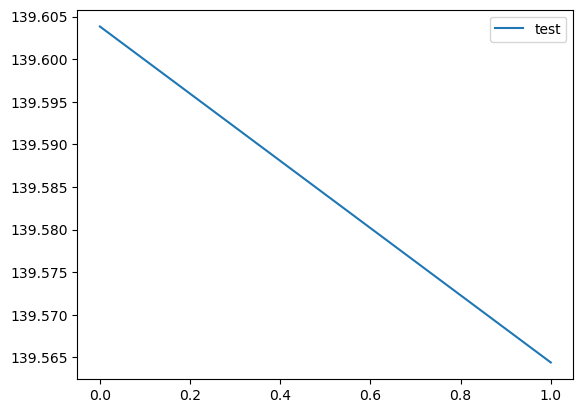

In [261]:
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

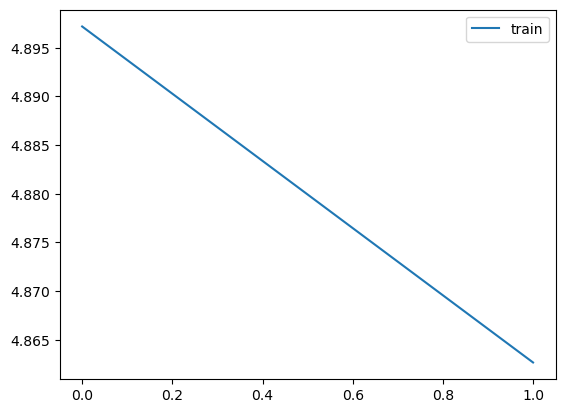

In [262]:
plt.plot(train_loss, label='train')
plt.legend()
plt.show()